# TH Nürnberg - Probevorlesung

In [1]:
#!pip3 install -r requirements.txt
#!pip3 install importlib-metadata==3.7.0

In [15]:
import pandas as pd
import matplotlib.pyplot as plt 
import datetime

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

def get_day_of_the_week(date_string: str):
    """ Determine the day of week for a given string date. """
    date_object = datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S').date()
    day_name = date_object.strftime("%A")
    return day_name

def extract_times(df: pd.DataFrame):
    """ Extract year, month, day etc from given datetime. """
    df['datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['Anfang'], format="%d.%m.%Y %H:%M") 
    df.rename(columns={"Gesamt (Netzlast) [MWh] Berechnete Auflösungen": "Stromverbrauch"}, inplace=True)
    df['Stromverbrauch'] = df['Stromverbrauch'].str.replace('.','').str.replace(',','.').astype(float)
    df['Year'] = df['datetime'].dt.year
    df['Month'] = df['datetime'].dt.month
    df['Day'] = df['datetime'].dt.day
    df['Hour'] = df['datetime'].dt.hour
    return df

# create a mapping of days of the week to numbers
day_of_week = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

In [16]:
# load data
df = pd.read_csv("data/Realisierter_Stromverbrauch_202201010000_202212312359_Stunde.csv", sep=';')

# convert date and time to datetime and extract year, month, day etc.
df = extract_times(df)

# use only necessary columns
df = df[['Stromverbrauch', 'datetime', 'Year', 'Month', 'Day', 'Hour']]#, 'day_of_week']]

In [17]:
df.head(211*24)

,Stromverbrauch,datetime,Year,Month,Day,Hour
0,43915.50,2022-01-01 00:00:00,2022,1,1,0
1,41535.75,2022-01-01 01:00:00,2022,1,1,1
2,40480.75,2022-01-01 02:00:00,2022,1,1,2
3,39564.00,2022-01-01 03:00:00,2022,1,1,3
4,39338.25,2022-01-01 04:00:00,2022,1,1,4
...,...,...,...,...,...,...
5059,44922.25,2022-07-30 20:00:00,2022,7,30,20
5060,43871.75,2022-07-30 21:00:00,2022,7,30,21
5061,42115.25,2022-07-30 22:00:00,2022,7,30,22
5062,39784.50,2022-07-30 23:00:00,2022,7,30,23


## 1. PyCaret Regression Model (univariate)

In [18]:
# Importiere das Regressionsmodul
from pycaret.regression import *
df['Id'] = df.index

# Splitte die Daten in Trainings-, Validierungs- und Testdaten  
train = df[df['datetime'] < "2022-07-01 00:00:00"]
val = df[(df['datetime'] >= "2022-07-01 00:00:00") & (df['datetime'] < "2022-08-01 00:00:00")]
test = df[(df['datetime'] >= "2022-08-01 00:00:00") & (df['datetime'] < "2022-08-31 00:00:00")]

### Training (univariat)

In [19]:
# initialize setup
s = setup(data = train, test_data = val, target = 'Stromverbrauch', fold_strategy = 'timeseries', 
          numeric_features = ['Month', 'Day', 'Hour', 'Id'], 
          categorical_features = [],
          fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,Session id,123
1,Target,Stromverbrauch
2,Target type,Regression
3,Original data shape,"(5087, 7)"
4,Transformed data shape,"(5087, 9)"
5,Transformed train set shape,"(4343, 9)"
6,Transformed test set shape,"(744, 9)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


In [20]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,5323.2676,44380765.4473,6616.3167,0.4059,0.1227,0.1030,0.0667
rf,Random Forest Regressor,5934.4228,62022915.9062,7736.8916,0.1759,0.1399,0.1155,0.0933
lightgbm,Light Gradient Boosting Machine,6000.9423,62679400.8034,7839.6582,0.1579,0.1420,0.1173,0.0633
et,Extra Trees Regressor,6025.3667,68194895.4336,8100.7751,0.0949,0.1456,0.1187,0.1033
gbr,Gradient Boosting Regressor,6723.1463,79000611.0740,8743.1942,-0.0504,0.1572,0.1330,0.0533
huber,Huber Regressor,7674.8481,85204322.0672,9149.5000,-0.1595,0.1642,0.1452,0.0433
en,Elastic Net,7808.0725,87414559.7257,9248.1755,-0.1901,0.1666,0.1487,0.4400
br,Bayesian Ridge,7807.4846,87421336.3815,9248.5676,-0.1902,0.1666,0.1487,0.0367
lasso,Lasso Regression,7951.9124,90737535.0517,9421.1724,-0.2333,0.1697,0.1522,0.4700
ridge,Ridge Regression,7971.8595,90827479.2580,9434.5896,-0.2330,0.1703,0.1532,0.4433


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,str,47042.2508,2237365873.0985,47300.8020,-10105.5044,2.5590,11.9503


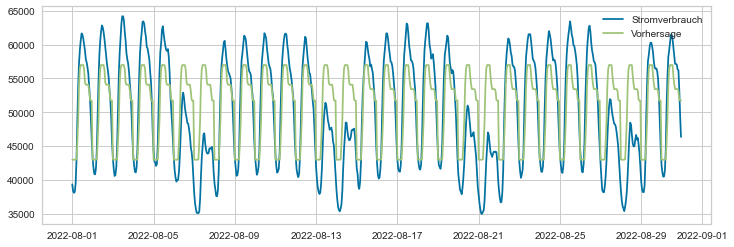

In [21]:
# generate predictions on the original dataset
final_best = finalize_model(best)
predictions = predict_model(final_best, data=test)

# plot ground truth and predictions
fig = plt.figure(figsize=(12,4))
plt.plot('datetime', 'Stromverbrauch', data=predictions, label='Stromverbrauch') 
plt.plot('datetime', 'prediction_label', data=predictions, label='Vorhersage') 
plt.legend()
plt.show()

In [ ]:
# Nachteil: Das Regressions-Modell macht keinen Unterschied zwischen Wochentagen.

## 2. PyCaret Regression Model (multivariate)

### Füge den Wochentag als Variable hinzu

In [22]:
# generate day of week (Mon=1, Tue=2, ... for given datetime)
df['day_of_week'] = df['datetime'].apply(lambda x: day_of_week[get_day_of_the_week(str(x))])

In [23]:
df.head(2)

,Stromverbrauch,datetime,Year,Month,Day,Hour,Id,day_of_week
0,43915.50,2022-01-01 00:00:00,2022,1,1,0,0,6
1,41535.75,2022-01-01 01:00:00,2022,1,1,1,1,6


In [24]:
# split data into train-test set
train = df[df['datetime'] < "2022-07-01 00:00:00"]
val = df[(df['datetime'] >= "2022-07-01 00:00:00") & (df['datetime'] < "2022-08-01 00:00:00")]
test = df[(df['datetime'] >= "2022-08-01 00:00:00") & (df['datetime'] < "2022-08-31 00:00:00")]

### Training (multivariat)

In [25]:
# import the regression module
from pycaret.regression import *

df['Id'] = df.index
# initialize setup
s = setup(data = train, test_data = val, target = 'Stromverbrauch', fold_strategy = 'timeseries', 
          numeric_features = ['Month', 'Day', 'Hour', 'Id'], 
          categorical_features = ['day_of_week'],             # nehme Wochentag hinzu => multivariat
          fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,Session id,123
1,Target,Stromverbrauch
2,Target type,Regression
3,Original data shape,"(5087, 8)"
4,Transformed data shape,"(5087, 16)"
5,Transformed train set shape,"(4343, 16)"
6,Transformed test set shape,"(744, 16)"
7,Numeric features,4
8,Date features,1
9,Categorical features,1


In [26]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3899.3650,26159397.1304,5005.4424,0.6527,0.0882,0.0726,0.1267
lightgbm,Light Gradient Boosting Machine,3965.5807,26719342.2373,5029.4941,0.6468,0.0901,0.0750,0.1033
rf,Random Forest Regressor,4026.6839,27915452.5695,5169.3501,0.6299,0.0911,0.0751,0.1267
dt,Decision Tree Regressor,4033.5534,29263060.9765,5301.2379,0.6115,0.0928,0.0749,0.0733
ada,AdaBoost Regressor,4866.3905,35212166.7595,5832.4405,0.5319,0.1084,0.0944,0.0833
gbr,Gradient Boosting Regressor,5095.4309,42889493.8118,6043.6082,0.4428,0.1085,0.0975,0.0833
llar,Lasso Least Angle Regression,6530.2054,65676367.7174,7965.9154,0.1025,0.1414,0.1226,0.0733
huber,Huber Regressor,6582.8252,66241248.8684,7999.2221,0.0946,0.1417,0.1234,0.0867
ridge,Ridge Regression,6632.5969,67968505.2801,8121.3652,0.0735,0.1447,0.1258,0.0833
lasso,Lasso Regression,6634.1877,67929943.1272,8104.5740,0.0729,0.1440,0.1253,0.0767


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,47763.8865,2343913003.3484,48413.9753,-10586.7932,2.5646,12.0082


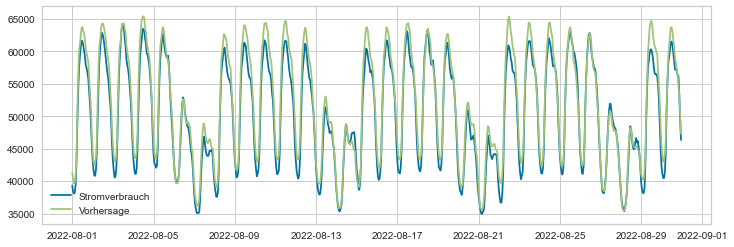

In [27]:
# generate predictions on the original dataset
final_best = finalize_model(best)
predictions = predict_model(final_best, data=test)

# plot ground truth and predictions
fig = plt.figure(figsize=(12,4))
plt.plot('datetime', 'Stromverbrauch', data=predictions, label='Stromverbrauch') 
plt.plot('datetime', 'prediction_label', data=predictions, label='Vorhersage') 
plt.legend()
plt.show()

## Gleitende Durchschnittsmodelle (MA-Modelle)

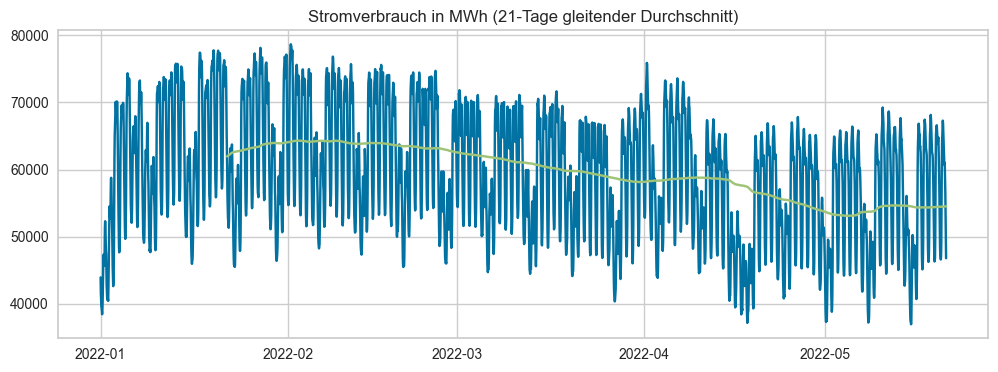

In [23]:
days = 140

# 21-Tage gleitender Durchschnitt berechnen
window = 21 * 24
df['MA21'] = df["Stromverbrauch"].rolling(window = window).mean()

# Plot
fig = plt.figure(figsize=(12,4))
plt.title('Stromverbrauch in MWh (21-Tage gleitender Durchschnitt)') 
plt.plot('datetime', 'Stromverbrauch', data=df.head(24*days)) 
plt.plot('datetime', 'MA21', data=df.head(24*days)) 
plt.show()

In [26]:
 # Autoregressive Modelle (AR(p)-Modelle)
 # Autoregressive gleitende Durchschnitte (AR-MA(p,q)-Modelle)  (Kombination eines autoregressiven und eines gleitende 
 #                                                               Durchschnittsmodells)
 # ARMA(p,q)–Modelle können für nicht-stationare Zeitreihen nicht verwendet werden -> Differenzenbildung
 #
 # ARIMA-Modelle bestehen aus drei Komponenten: 
 #   Autoregression (AR) - bezieht sich auf eine Reihe von laufenden Werte
 #   Integration (I) - Differenz zwischen zwei aufeinanderfolgenden Werten 
 #   Moving Average (MA) -  bezieht sich auf die Kombination von n aufeinanderfolgenden Werten.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean = 0.5

t = np.arange(0,40,0.1)

y = np.zeros(len(t))

var1=1.0
var2=1.0
for i in range(len(t)):
    if t[i] < 10:
        y[i] = np.random.normal(loc=mean, scale=var1)
    elif t[i] >= 10 and t[i] < 20:
        y[i] = np.random.normal(loc=mean, scale=var2)
    elif t[i] >= 20 and t[i] < 30:
        y[i] = np.random.normal(loc=mean, scale=var1)
    else:
        y[i] = np.random.normal(loc=mean, scale=var2)

plt.plot(t,y)
plt.xlabel('Zeit')
plt.ylabel('Wert')
plt.title("Varianz nicht konstant (nicht stationär)")
plt.show()

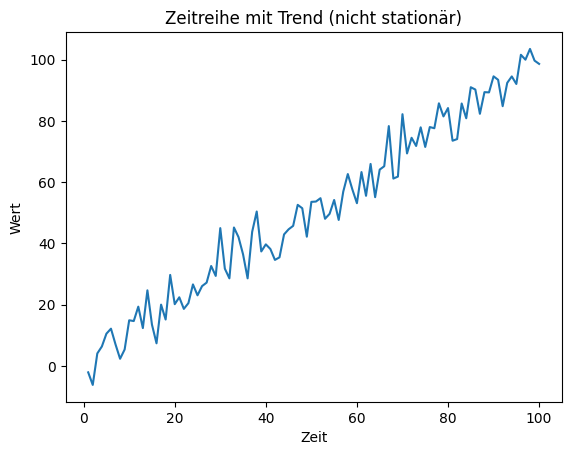

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# generate time series
time_series = np.arange(1, 101)

# calculate standard deviation
std_dev = 5

# generate  time series
stationary_ts = time_series + np.random.normal(0, std_dev, 100)

# plot the stationary time series
plt.plot(time_series, stationary_ts)
plt.title('Zeitreihe mit Trend (nicht stationär)')
plt.xlabel('Zeit')
plt.ylabel('Wert')
plt.show()

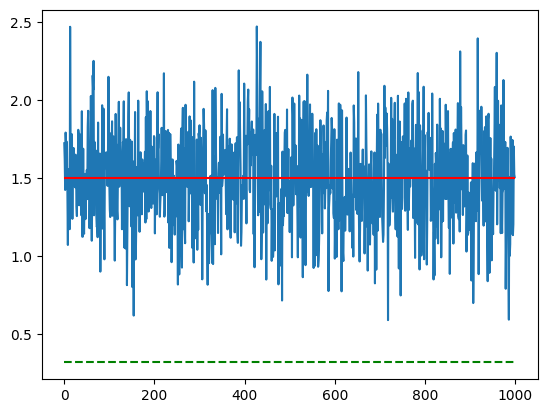

In [47]:
import matplotlib.pyplot as plt 
import numpy as np 

#define parameters
expectation_value = 1.5
variance = 0.1

#generate random numbers
x = np.random.randn(1000)*np.sqrt(variance) + expectation_value

#plot time series
plt.plot(x)

#add line for expectation value
plt.hlines(expectation_value, 0, 1000, colors='r', linestyles='solid')

#add line for variance
plt.hlines(np.sqrt(variance), 0, 1000, colors='g', linestyles='dashed')

plt.show()

In [ ]:
days = 140

# 21-Tage gleitender Durchschnitt berechnen
window = 21 * 24
df['MA21'] = df["Stromverbrauch"].rolling(window = window).mean()

# Plot
fig = plt.figure(figsize=(12,4))
plt.title('Stromverbrauch in MWh (21-Tage gleitender Durchschnitt)') 
plt.plot('datetime', 'Stromverbrauch', data=df.head(24*days)) 
plt.plot('datetime', 'MA21', data=df.head(24*days)) 
plt.show()

In [ ]:
import pandas as pd

# Daten lesen aus CSV-Datei
df = pd.read_csv("Stromverbrauch.csv")

# konvertiere den String-Timestamp (z.B. "01.01.2022 08:00") in einen datetime64 Timestamp
df['datetime'] = pd.to_datetime(df['datetime_str'], format="%d.%m.%Y %H:%M") 

# Beginne mit dem Modell
...

In [ ]:
# Splitte die Daten in Trainings- und Testdaten  
train = df[df['datetime'] < "2022-08-01 00:00:00"]
test = df[(df['datetime'] >= "2022-08-01 00:00:00") & (df['datetime'] < "2022-08-31 00:00:00")]

In [7]:
import numpy as np
for n in range(1,14):
    print(n, np.round(1-0.8**n,2)) 

1 0.2
2 0.36
3 0.49
4 0.59
5 0.67
6 0.74
7 0.79
8 0.83
9 0.87
10 0.89
11 0.91
12 0.93
13 0.95
